<a href="https://colab.research.google.com/github/rdolor/MLPlayground/blob/master/Titanic/preprocess-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
import json
with open('kaggle.json') as f:
  kaggle_api = json.load(f)
  
import os
os.environ['KAGGLE_USERNAME'] = kaggle_api['username']
os.environ['KAGGLE_KEY'] = kaggle_api['key']

In [6]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
ls

gender_submission.csv  kaggle.json  sample_data/  test.csv  train.csv


In [0]:
import pandas as pd
import matplotlib
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

## 1. Load the data

In [9]:
train = pd.read_csv("train.csv",header=0)
test = pd.read_csv("test.csv",header=0)
print('train and test shape = ', train.shape, test.shape)
print('label name', set(train.columns) - set(test.columns))

train and test shape =  (891, 12) (418, 11)
label name {'Survived'}


#### Sample of data

In [10]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### Information

|Variable|Definition|Key|
|---|---|---|
|survival|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years|	
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked|	Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|### Information



#### Features data type

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* The data is a mixture of numerical features and categorical ones.

#### Number of missing values

##### Training data:

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
'% of missing values in Training data = Age: {}, Cabin:{}'.format(100*(177/891), 100*(687/891))

'% of missing values in Training data = Age: 19.865319865319865, Cabin:77.10437710437711'

* `Cabin` has so many missing values to be useful, will drop it. Imputing its information may cause a lot of noise.

In [0]:
train.drop('Cabin', axis=1, inplace=True)

##### Test data:

In [15]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

* In real life, we will really not know which features will have missing values. It's best to give default values for each feature.
* For this competition, for convenience, I will just create default values for those features I know have missing values on test file.

#### Number of unique elements in each column

In [16]:
for col in train.columns:
    print('{} : {}'.format(col,len(set(train[col]))))

PassengerId : 891
Survived : 2
Pclass : 3
Name : 891
Sex : 2
Age : 265
SibSp : 7
Parch : 7
Ticket : 681
Fare : 248
Embarked : 4


* each row has a unique PassengerId
* `Name` and `Ticket` have to be parsed to collect useful information

## 2. Visualize the relationship of each column with the label

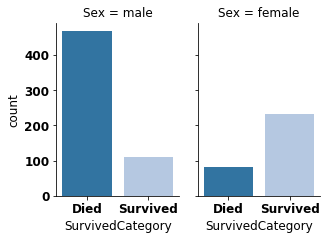

In [17]:
train["SurvivedCategory"] = train.Survived.map(lambda x: "Survived" if x > 0 else "Died")

g = sns.catplot("SurvivedCategory", col="Sex", col_wrap=4,
                data=train,
                kind="count", height=3.5, aspect=.6, 
                palette='tab20')

plt.show()

* More male did not survive

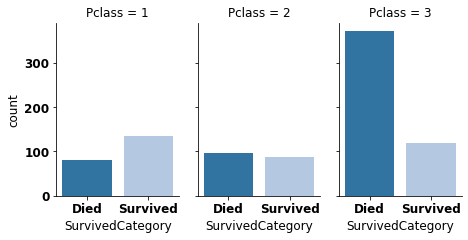

In [18]:
g = sns.catplot("SurvivedCategory", col="Pclass", col_wrap=4,
                data=train,
                kind="count", height=3.5, aspect=.6, 
                palette='tab20')

plt.show()

* Class 3 did not survive the most

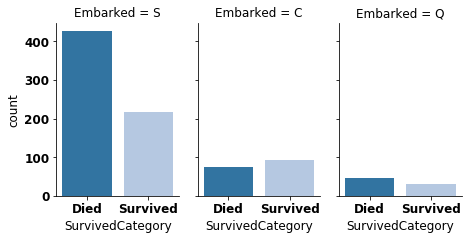

In [19]:
g = sns.catplot("SurvivedCategory", col="Embarked", col_wrap=4,
                data=train[train.Embarked.notnull()],
                kind="count", height=3.5, aspect=.6, 
                palette='tab20')

plt.show()

* There are so many people who embarked at "S"
* Embarkation "S" has the biggest gap of dying and surviving

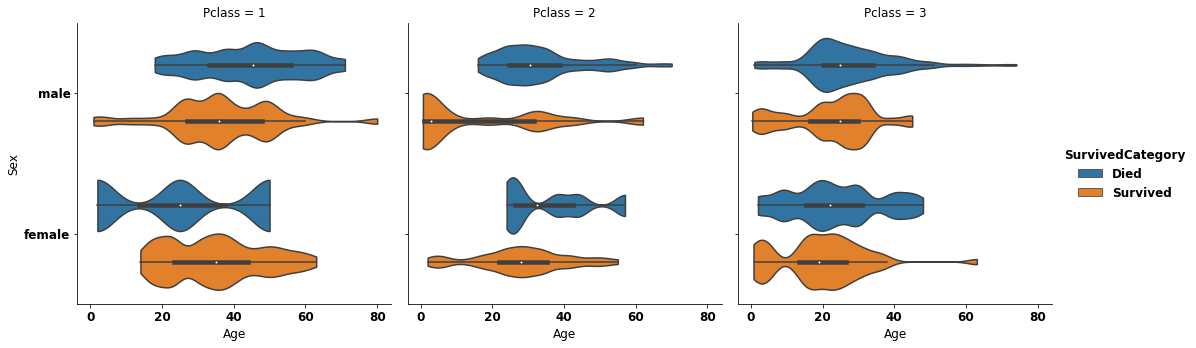

In [20]:
sns.catplot(x="Age", y="Sex",
            hue="SurvivedCategory", col="Pclass",
            data=train[train.Age.notnull()],
            orient="h", height=5, aspect=1, palette="tab10",
            kind="violin", dodge=True, cut=0, bw=.2)

* There's a different distribution of dying and surviving given the three features -- Age, Sex, and Class
* There is a meaningful interaction between these three features

In [21]:
for col in ['Pclass', 'Sex', 'Embarked']:
    print(col)
    print(train[[col, 'Survived']].groupby([col], as_index=False).mean().sort_values(by="Survived", ascending=False))
    print()

Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908

Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957



* There is higher chance of surviving for having Class 1, being Female, and embarking in C.

<Figure size 800x640 with 0 Axes>

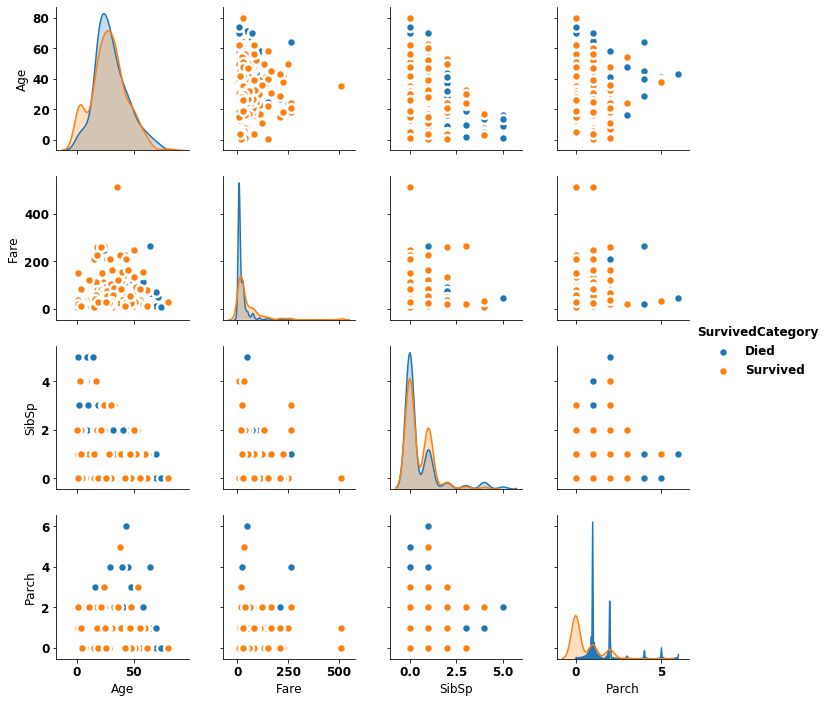

In [22]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(train[train.Age.notnull()][["SurvivedCategory","Age","Fare","SibSp","Parch"]], kind="scatter", hue="SurvivedCategory", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

* Most obvious difference in distribution of Survival in the `Fare` feature; Those who died have lower fare

## 3. Feature engineering

#### Fill in missing values of `Embark` with most frequent value

In [23]:
print('Most frequent embarkation is : ',train.Embarked.dropna().mode()[0])
train['Embarked'] = train['Embarked'].fillna(train.Embarked.dropna().mode()[0])

Most frequent embarkation is :  S


#### Make use of the `Name` by parsing some information from it

In [24]:
train.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

##### Title of people can approximate for their age, position, and wealth

In [25]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [26]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


* The young ones -- Master and Miss -- have high chance of surviving
* Actually, it is more of gender.. women, such as "Miss" and "Mrs" have highest chance of surviving

##### How about surnames?

In [27]:
train['LastName'] = train['Name'].map(lambda x: x.split(",")[0])
total = train[['LastName', 'Survived']].groupby(['LastName'], as_index=False).count()
count_survived = train[['LastName', 'Survived']].groupby(['LastName'], as_index=False).sum()
merged = pd.merge(total,count_survived,how='inner',on="LastName")
merged.columns = ['LastName','Total','Number survived']
merged['Ratio'] = merged['Number survived']/merged['Total']
merged.sort_values('Ratio', ascending=False)

,LastName,Total,Number survived,Ratio
333,Lehmann,1,1,1.0
215,Glynn,1,1,1.0
249,Hedman,1,1,1.0
248,Healy,1,1,1.0
247,Hays,2,2,1.0
...,...,...,...,...
278,Isham,1,0,0.0
277,Ilmakangas,1,0,0.0
274,Ibrahim Shawah,1,0,0.0
273,Hunt,1,0,0.0


In [28]:
agg = train[['LastName', 'Survived']].groupby(['LastName'], as_index=False).sum()
LastNameSurvivors = list(agg[agg['Survived'] > 0]['LastName'])
train['LastNameSurvived'] = train['LastName'].map(lambda x: 1 if x in LastNameSurvivors else 0)
train[['LastNameSurvived', 'Survived']].groupby(['LastNameSurvived'], as_index=False).mean()

,LastNameSurvived,Survived
0,0,0.000000
1,1,0.812352


* Not sure if this will help.. it might overfit the training. It will be a matter of how I am going to use this information.


#### Size of family can be computed from `SibSp` and `Parch`

In [0]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

#### Fill missing values of `Age`

* Filling it up with its average value is misleading
* Check first how it relates with other features

##### Relationship of `Age` with other features

* Look at the relationship of Age with other features
* Convert all to numerics

In [30]:
train.dropna()[['Sex','Age']].groupby(['Sex']).mean().reset_index()

,Sex,Age
0,female,27.915709
1,male,30.726645


In [31]:
train.dropna()[['Pclass','Age']].groupby(['Pclass']).mean().reset_index()

,Pclass,Age
0,1,38.233441
1,2,29.877630
2,3,25.140620


In [32]:
train.dropna()[['Sex','Pclass','Age']].groupby(['Sex','Pclass']).mean().reset_index()

,Sex,Pclass,Age
0,female,1,34.611765
1,female,2,28.722973
2,female,3,21.750000
3,male,1,41.281386
4,male,2,30.740707
5,male,3,26.507589


* Average age decreases with `Pclass` and is different distribution for `Sex`

In [0]:
import math
def impute_age(row):
    if math.isnan(row["Age"]):
        if row['Sex'] == 'female' and row['Pclass'] == 1:
            return 34.61
        elif row['Sex'] == 'female' and row['Pclass'] == 2:
            return 28.72
        elif row['Sex'] == 'female' and row['Pclass'] == 3:
            return 21.75
        elif row['Sex'] == 'male' and row['Pclass'] == 1:
            return 41.28
        elif row['Sex'] == 'male' and row['Pclass'] == 2:
            return 30.74
        elif row['Sex'] == 'male' and row['Pclass'] == 3:
            return 26.51
        else:
            return 0.
    
    else:
        return row["Age"]      

In [0]:
train["Age"] = train.apply(lambda row: impute_age(row),axis=1)

#### Fill missing values of `Fare`

In [35]:
train.dropna()[['Pclass','Fare']].groupby(['Pclass']).mean().reset_index()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


* Average `Fare` decreases with `Pclass`

In [0]:
def impute_fare(row):
    if math.isnan(row["Fare"]):
        if row['Pclass'] == 1:
            return 84.15
        elif row['Pclass'] == 2:
            return 20.66
        elif row['Pclass'] == 3:
            return 13.68
        else:
            return 0.
    
    else:
        return row["Fare"]      

In [0]:
train["Fare"] = train.apply(lambda row: impute_fare(row),axis=1)

##### Check missing values again

In [38]:
train.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Embarked            0
SurvivedCategory    0
Title               0
LastName            0
LastNameSurvived    0
FamilySize          0
dtype: int64

* It is possible that the way the missing values are imputed can degrade the quality of predictions
* Can try predicting the survival, when the missing values are dropped rather than imputed

#### Create buckets for `Age` and `Fare`

* Ordinal features are sometimes better inputs for some algorithms, especially tree-based ones

In [39]:
train['Age_bucket'] = pd.cut(train['Age'], 5)
train[['Age_bucket', 'Survived']].groupby(['Age_bucket'], as_index=False).mean().sort_values(by='Age_bucket', ascending=True)

,Age_bucket,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.336714
2,"(32.252, 48.168]",0.412844
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


* The chance of survival decreases from youngest to oldest

In [0]:
train['Age_bucket'] =  train.Age
train.loc[ train['Age'] <= 16, 'Age_bucket'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age_bucket'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age_bucket'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age_bucket'] = 3
train.loc[train['Age'] > 64, 'Age_bucket'] = 4
train['Age_bucket'] = train['Age_bucket'].astype(int)

In [41]:
train['Fare_bucket'] = pd.qcut(train['Fare'], 4)
train[['Fare_bucket', 'Survived']].groupby(['Fare_bucket'], as_index=False).mean().sort_values(by='Fare_bucket', ascending=True)

,Fare_bucket,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


* The higher the fare, the higher the chance of surviving

In [0]:
train['Fare_bucket'] = train.Fare
train.loc[ train['Fare'] <= 7.91, 'Fare_bucket'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare_bucket'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31.0), 'Fare_bucket']   = 2
train.loc[ train['Fare'] > 31.0, 'Fare_bucket'] = 3
train['Fare_bucket'] = train['Fare_bucket'].astype(int)

* Can also check the interaction of two variables

In [0]:
train['Age_bucket*Class'] = train.Age_bucket * train.Pclass
train['Fare_bucket*Class'] = train.Fare_bucket * train.Pclass

## Correlation

In [44]:
categorical_features = ['Survived','Pclass', 'Sex', 'Embarked', 'Title']
numerical_features   = ['Age', 'SibSp','Parch', 'Fare','FamilySize',
                        'Age_bucket', 'Fare_bucket','Age_bucket*Class','Fare_bucket*Class']


from sklearn.preprocessing import LabelEncoder

catego_le = LabelEncoder()
for feature in categorical_features:
    train[feature] = catego_le.fit_transform(train[feature].values)
    
corr = train[['Survived'] + numerical_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Survived,Age,SibSp,Parch,Fare,FamilySize,Age_bucket,Fare_bucket,Age_bucket*Class,Fare_bucket*Class
Survived,1,-0.067,-0.035,0.082,0.26,0.017,-0.036,0.3,-0.27,0.071
Age,-0.067,1,-0.25,-0.18,0.12,-0.26,0.94,0.12,0.63,-0.18
SibSp,-0.035,-0.25,1,0.41,0.16,0.89,-0.23,0.39,-0.23,0.59
Parch,0.082,-0.18,0.41,1,0.22,0.78,-0.15,0.39,-0.13,0.53
Fare,0.26,0.12,0.16,0.22,1,0.22,0.15,0.58,-0.24,0.18
FamilySize,0.017,-0.26,0.89,0.78,0.22,1,-0.23,0.47,-0.23,0.67
Age_bucket,-0.036,0.94,-0.23,-0.15,0.15,-0.23,1,0.13,0.68,-0.18
Fare_bucket,0.3,0.12,0.39,0.39,0.58,0.47,0.13,1,-0.35,0.73
Age_bucket*Class,-0.27,0.63,-0.23,-0.13,-0.24,-0.23,0.68,-0.35,1,-0.21
Fare_bucket*Class,0.071,-0.18,0.59,0.53,0.18,0.67,-0.18,0.73,-0.21,1


* Highly correlated features can be chosen not to go together to avoid repetition of information. Some linear algorithms are sensitive to correlation.